In [1]:
from IPython.display import Image, FileLink
import pandas.rpy.common as com

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(data.table)
library(dplyr)

data.table 1.9.4  For help type: ?data.table
*** NB: by=.EACHI is now explicit. See README to restore previous behaviour.

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, last

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
%%R
blastout_dt = fread("../data/tmp/blast_out_otusn_LTP115.m6")
blastout_df = tbl_df(blastout_dt)
colnames(blastout_df) = c("OTU",
                        "acc",
                        "pid",
                        "aln.length",
                        "mismatches",
                        "gapOpenCount",
                        "qstart",
                        "qend",
                        "sstart",
                        "send",
                        "e.value",
                        "bit.score")

top_hits_df_LTP = blastout_df %.% 
                          group_by(OTU) %.% 
                          mutate(Rank = rank(desc(bit.score), ties.method = "min")) %.% 
                          filter(Rank == 1)

In [5]:
%%R
dt = fread("/var/seq_data/LTP115_db/LTPs115_SSU.csv", sep = ";", header = FALSE)
colnames(dt) = c("acc","start","end","DB.version","name","unknown1","family","unknown2","url","full_tax")
LTP_seq_data = tbl_df(dt)

In [6]:
%%R
joined_df = left_join(top_hits_df_LTP, LTP_seq_data)

Joining by: "acc"


In [7]:
%%R
df.l2fc = read.table("../data/l2fc_table.csv", sep = ",", header = TRUE, stringsAsFactors = FALSE)
df.l2fc.summary = df.l2fc %.% filter(test == "greater") %.% group_by(OTU) %.% summarize(m = max(log2FoldChange), 
                                                          Rank2 = first(Rank2), 
                                                          Rank6 = first(Rank6),
                                                          Rank3 = first(Rank3),
                                                          Rank5 = first(Rank5),
                                                          minP = min(p.adj)) %.% arrange(desc(m))

In [8]:
%%R
df.l2fc.summary

Source: local data frame [655 x 7]

        OTU        m            Rank2                Rank6
1   OTU.470 4.435180 Gemmatimonadetes                   NA
2  OTU.2036 3.906883   Proteobacteria          Pseudomonas
3   OTU.528 3.548746       Firmicutes       Incertae_Sedis
4   OTU.321 3.404477   Proteobacteria     Stenotrophomonas
5  OTU.1276 3.289709   Actinobacteria                   NA
6    OTU.14 3.272428   Proteobacteria Escherichia-Shigella
7    OTU.54 3.193468   Proteobacteria Escherichia-Shigella
8   OTU.330 3.161807       Firmicutes          Clostridium
9   OTU.697 3.159696   Proteobacteria          Pseudomonas
10  OTU.761 3.132044       Firmicutes                   NA
..      ...      ...              ...                  ...
Variables not shown: Rank3 (chr), Rank5 (chr), minP (dbl)


In [9]:
%%R
FDR = 0.10
rspndr_df = df.l2fc.summary %.% filter(minP <= FDR)
rspndr_otus = rspndr_df$OTU
table_df = joined_df %.% filter(OTU %in% rspndr_otus)

In [10]:
%%R
table_df = left_join(table_df, df.l2fc.summary %.% select(OTU, Rank2))

Joining by: "OTU"


In [11]:
%%R
N = 10 
topN = (rspndr_df %.% arrange(desc(m)))[1:N,]
topN_otus = topN$OTU
table_df$topN = ifelse(table_df$OTU %in% topN_otus, "yes", "no")

In [12]:
%%R
table_df = table_df %.% arrange(Rank2, name)

In [13]:
df = com.load_data("table_df")

In [16]:
def species_str(s):
    genera = []
    sp = []
    for i in s.values:
        genus, species = i.split(" ",1)
        if genus in genera:
            sp.append(genus[0] + "." + "~" + species.replace(" ", "~"))
        else:
            sp.append(i.replace(" ", "~"))
        genera.append(genus)
    return ", ".join(sp)

In [17]:
def get_genera(s):
    genera = []
    for i in s.values:
        genus, species = i.split(" ",1)
        genera.append(genus)
    return ", ".join(list(set(genera)))

In [18]:
def get_latex(df):
    latex = ""
    OTU = df.OTU.iloc[0]
    #species = species_str(df["name"])
    genera = get_genera(df["name"])
    pid = df.pid.iloc[0]
    phylum = df.Rank2.iloc[0]
    topN = df.topN.iloc[0]
    #acc = df.acc.iloc[0]
    return OTU + " & " + genera + " & " + str(pid) + " & " + topN + " & " + phylum + r" \\ " + r"\midrule" + "\n"
    #return OTU + " & " + str(pid) + r" \\ " + r"\midrule" + "\n"

In [19]:
def get_tsv(df):
    latex = ""
    OTU = df.OTU.iloc[0]
    genera = get_genera(df["name"])
    pid = df.pid.iloc[0]
    phylum = df.Rank2.iloc[0]
    topN = df.topN.iloc[0]
    return OTU + "\t" + genera + "\t" + str(pid) + "\t" + topN + "\t" + phylum + "\n"

In [25]:
with open("../data/LTP_blast_table.tsv", "w") as out:
    out.write("OTU_ID\tGenera_of_top_hits\tBLAST_%ID\ttop_10?\tPhylum\n")
    for l in df.sort("full_tax").groupby("OTU").apply(get_tsv):
        out.write(l)

In [44]:
%%bash 
head -1 ../data/LTP_blast_table.tsv > ../data/LTP_blast_table.sorted.tsv
sed 1d ../data/LTP_blast_table.tsv | sort -t $'\t' -k5 -k2 >> ../data/LTP_blast_table.sorted.tsv
head ../data/LTP_blast_table.sorted.tsv

OTU_ID	Genera_of_top_hits	BLAST_%ID	top_10?	Phylum
OTU.1276	Agromyces	99.49	yes	Actinobacteria
OTU.282	Nocardia, Rhodococcus	100.0	no	Actinobacteria
OTU.140	Bacillus	100.0	no	Firmicutes
OTU.3	Bacillus	100.0	no	Firmicutes
OTU.243	Bacillus	98.98	no	Firmicutes
OTU.419	Caloramator	93.88	no	Firmicutes
OTU.108	Caloramator	96.94	no	Firmicutes
OTU.227	Cellulosilyticum	93.4	no	Firmicutes
OTU.327	Clostridium	94.92	no	Firmicutes


In [45]:
FileLink("../data/LTP_blast_table.sorted.tsv")

/home/chuck/working/NSIP_data_analysis/data/LTP_blast_table.sorted.tsv

In [20]:
s = df.groupby("OTU").apply(get_latex)

table_framework = r"""
\documentclass[11pt]{article}
\usepackage{multirow, array, booktabs}
\begin{document}

\thispagestyle{empty}
 
\begin{table}[ht]
\caption{$^{15}$N responders BLAST against Living Tree Project}
\begin{center}
\begin{tabular}{llrll}
    \toprule \\
    \textbf{OTU ID} & \textbf{Genera of top hits} & \textbf{BLAST \%%ID} & \textbf{top 10?} & \textbf{Phylum} \\
    \midrule
    %s
    \bottomrule
\end{tabular}
\end{center}
\label{tab:multicol}
\end{table}
 
\end{document}"""%"".join(s.values)

with open("../data/tmp/table.tex", "w") as out:
    out.write(table_framework)

In [21]:
!latex ../data/tmp/table.tex
!dvipng -o figs/LTP_blast_table.png table.dvi

This is pdfTeX, Version 3.1415926-1.40.10 (TeX Live 2009/Debian)
entering extended mode
(../data/tmp/table.tex
LaTeX2e <2009/09/24>
Babel <v3.8l> and hyphenation patterns for english, usenglishmax, dumylang, noh
yphenation, farsi, arabic, croatian, bulgarian, ukrainian, russian, czech, slov
ak, danish, dutch, finnish, french, basque, ngerman, german, german-x-2009-06-1
9, ngerman-x-2009-06-19, ibycus, monogreek, greek, ancientgreek, hungarian, san
skrit, italian, latin, latvian, lithuanian, mongolian2a, mongolian, bokmal, nyn
orsk, romanian, irish, coptic, serbian, turkish, welsh, esperanto, uppersorbian
, estonian, indonesian, interlingua, icelandic, kurmanji, slovenian, polish, po
rtuguese, spanish, galician, catalan, swedish, ukenglish, pinyin, loaded.
(/usr/share/texmf-texlive/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texmf-texlive/tex/latex/base/size11.clo))
(/usr/share/texmf-texlive/tex/latex/multirow/multirow.st

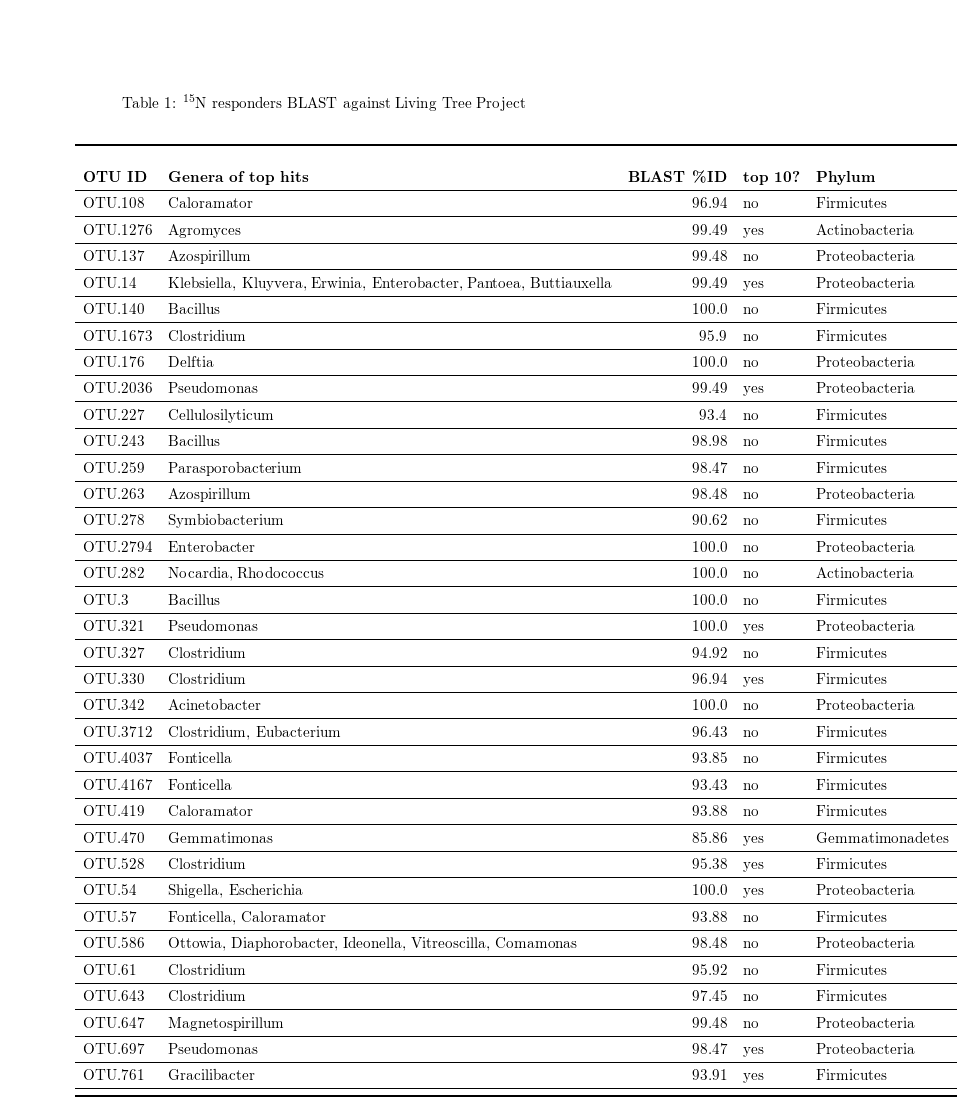

In [22]:
Image("figs/LTP_blast_table.png")

In [23]:
FileLink("figs/LTP_blast_table.png")

/home/chuck/working/NSIP_data_analysis/figures_and_stats/figs/LTP_blast_table.png

In [24]:
FileLink("../data/tmp/table.tex")

/home/chuck/working/NSIP_data_analysis/data/tmp/table.tex

In [25]:
%%R
sessionInfo()

R version 3.1.2 (2014-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] dplyr_0.3.0.2    data.table_1.9.4

loaded via a namespace (and not attached):
 [1] assertthat_0.1 chron_2.3-45   DBI_0.3.1      lazyeval_0.1.9 magrittr_1.0.1
 [6] parallel_3.1.2 plyr_1.8.1     Rcpp_0.11.3    reshape2_1.4   stringr_0.6.2 
